In [81]:
import os
import sys
while not os.getcwd().endswith('ml'):
    os.chdir('..')
sys.path.insert(0, os.getcwd())

In [83]:
import pandas as pd
import numpy as np
import copy
import matplotlib.pyplot as plt
import pickle
import spacy
import random
from collections import defaultdict
from spacy.util import minibatch, compounding
from spacy.lang.en import English
from kaggle_problems.tweet_sentiment_extraction.common import *

from libs.nlp.ner.ner import NER
from helpers.word2vec.converter import *

In [84]:
MAIN_PART_LABEL = 'MAIN_PART_LABEL'

In [85]:
train = pd.read_csv("kaggle_problems/tweet_sentiment_extraction/train.csv")
test = pd.read_csv("kaggle_problems/tweet_sentiment_extraction/test.csv")

train.dropna(inplace=True)
train.reset_index(drop=True, inplace=True)
test.dropna(inplace=True)
test.reset_index(drop=True, inplace=True)

In [86]:
def preprocessing_column(column):
    #column = column.apply(lambda x: ''.join([i for i in x if (i.isalpha() or i == ' ')]))
    #column = column.apply(lambda x: re.sub(' +', ' ', x))
    
    #column = column.apply(lambda x: x[1:] if x.startswith(' ') else x)
    #column = column.apply(lambda x: x[:-1] if x.endswith(' ') else x)
    
    return column

def preprocessing(data):
    data.text = preprocessing_column(data.text)
    data['text_words'] = data['text'].apply(lambda x: x.split(" "))
    data['text_cnt_words'] = data['text'].apply(lambda x: len(x.split(" ")))
    
    if 'selected_text' in data.columns:
        data.selected_text = preprocessing_column(data.selected_text)
        data['selected_text_words'] = data['selected_text'].apply(lambda x: x.split(" "))
        data['selected_text_cnt_words'] = data['selected_text'].apply(lambda x: len(x.split(" ")))
    
    return data

In [87]:
train = preprocessing(train)
test = preprocessing(test)

### Гипотеза что расстояние джакара между selected_texts and texts маленькое для text_cnt_words < X

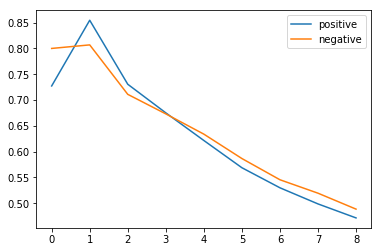

In [88]:
jacard_dist = defaultdict(list)
for sentiment in ['positive', 'negative']:
    for i in range(1, 10):
        msk = (train['text_cnt_words'] <= i) & (train['sentiment'] == sentiment)
        texts = train[msk]['text']
        selected_texts = train[msk]['selected_text']
        jacard_dist[sentiment].append(arr_jaccard(texts, selected_texts))
        
for sentiment in ['positive', 'negative']:
    plt.plot(jacard_dist[sentiment], label=sentiment)
plt.legend()
plt.show()

Created blank 'en' model
Loaded model 'kaggle_problems/tweet_sentiment_extraction/models/ner_positive'
Created blank 'en' model
Loaded model 'kaggle_problems/tweet_sentiment_extraction/models/ner_negative'


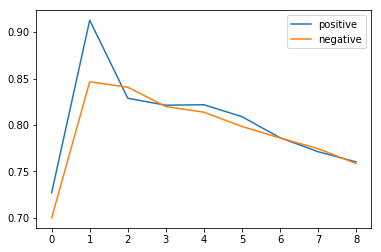

In [89]:
jacard_dist = defaultdict(list)
for sentiment in ['positive', 'negative']:
    model = NER()
    model.load_model('kaggle_problems/tweet_sentiment_extraction/models/ner_{}'.format(sentiment))
    for i in range(1, 10):
        msk = (train['text_cnt_words'] <= i) & (train['sentiment'] == sentiment)
        
        predict_selected_texts = predict(model, train[msk])
        selected_texts = train[msk].selected_text.to_numpy()

        jacard_dist[sentiment].append(arr_jaccard(selected_texts, predict_selected_texts))
        
        
for sentiment in ['positive', 'negative']:
    plt.plot(jacard_dist[sentiment], label=sentiment)
plt.legend()
plt.show()

In [90]:
def df_to_spacy_format(data):
    data.reset_index(drop=True, inplace=True)
    spacy_data  = [0] * len(data)
    for ind, line in data.iterrows():
#         print("-" * 100)
#         print(ind)
        start_word, end_word = get_start_end_char(line)
        spacy_data[ind] = (
            line['text'], 
            {"entities": [(start_word, end_word, MAIN_PART_LABEL)]}
        )
#         nlp = English()
#         tokens = nlp(line['text'])

#         print([t.text for t in tokens])
#         print(line['text'])
#         print(start_word, end_word)
#         print(line['selected_text'])
#         print(spacy.gold.biluo_tags_from_offsets(nlp.make_doc(line['text']), [(start_word, end_word, MAIN_PART_LABEL)]))
#         print("-" * 100)
    return spacy_data


### Training

In [91]:
for sentiment in ['positive', 'negative', 'neutral']:
    print("Training for {}".format(sentiment))
    print("-" * 100)
    model = NER(evaluate_score=evaluate_score)
    spacy_train_pos = df_to_spacy_format(train[train['sentiment'] == sentiment])
    train_los, validation_los = model.train(spacy_train_pos, n_iter=30)
    model.save_model('kaggle_problems/tweet_sentiment_extraction/models/ner_{}'.format(sentiment))
    pickle.dump(train_los, open("kaggle_problems/tweet_sentiment_extraction/data/baseline/train_los.pkl", 'wb'))
    pickle.dump(validation_los, open("kaggle_problems/tweet_sentiment_extraction/data/baseline/validation_los.pkl", 'wb'))
    
    print("-" * 100)

Training for positive
----------------------------------------------------------------------------------------------------
Created blank 'en' model


/Users/skrrydg/anaconda3/lib/python3.7/site-packages/spacy/language.py:639: UserWarning: [W033] Training a new parser or NER using a model with no lexeme normalization table. This may degrade the performance of the model to some degree. If this is intentional or the language you're using doesn't have a normalization table, please ignore this warning. If this is surprising, make sure you have the spacy-lookups-data package installed. The languages with lexeme normalization tables are currently: da, de, el, en, id, lb, pt, ru, sr, ta, th.
  **kwargs
  0%|          | 0/30 [00:30<?, ?it/s]


KeyboardInterrupt: 

In [ ]:
train_los = pickle.load(open("kaggle_problems/tweet_sentiment_extraction/data/baseline/train_los.pkl", 'rb'))
validation_los =pickle.load(open("kaggle_problems/tweet_sentiment_extraction/data/baseline/validation_los.pkl", 'rb'))
    
plt.plot(train_los, label='train_los')
plt.plot(validation_los, label='validation_los')
plt.legend()
plt.show()

In [ ]:
print(train_los, validation_los)

### Predict on train

In [ ]:
prediction = {}
for sentiment in ['positive', 'negative']:
    model = NER()
    model.load_model('kaggle_problems/tweet_sentiment_extraction/models/ner_{}'.format(sentiment))
    
    predict_selected_texts = predict(model, train[train['sentiment'] == sentiment])
    selected_texts = train[train['sentiment'] == sentiment].selected_text.to_numpy()
        
    print(arr_jaccard(selected_texts, predict_selected_texts))

### Predict on test

In [ ]:
result_df = pd.DataFrame(columns=['textID', 'selected_text'])
for sentiment in ['positive', 'negative']:
    model = NER()
    model.load_model('kaggle_problems/tweet_sentiment_extraction/models/ner_{}'.format(sentiment))
    
    predict_selected_texts = predict(model, test[test['sentiment'] == sentiment])
    
    result_df = result_df.append(
        pd.DataFrame(
            data={'textID': test[test['sentiment'] == sentiment].textID.to_numpy(),
                  'selected_text': predict_selected_texts}, 
            columns=['textID', 'selected_text'],
        )
    )
    
result_df = result_df.append(
    pd.DataFrame(
        data={'textID': test[test['sentiment'] == 'neutral'].textID.to_numpy(),
              'selected_text': test[test['sentiment'] == 'neutral'].text.to_numpy()}, 
        columns=['textID', 'selected_text'],
    )
)
result_df = result_df.set_index('textID')


In [ ]:
result_df.to_csv('kaggle_problems/tweet_sentiment_extraction/submissions/{}'.format('baseline_ner'))

In [92]:
!jupyter nbconvert --to script kaggle_problems/tweet_sentiment_extraction/baseline.ipynb

[NbConvertApp] Converting notebook kaggle_problems/tweet_sentiment_extraction/baseline.ipynb to script
[NbConvertApp] Writing 6717 bytes to kaggle_problems/tweet_sentiment_extraction/baseline.py
